<h2>Data Integration</h2>

<h3>Imports<h3>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import seaborn as sns
from pathlib import Path
from datetime import date
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

<p>Reading the document<p>

In [3]:
#Open Excel files with different extensions
filename = 'train.csv'
file_path = Path(filename)
file_extension = file_path.suffix.lower()[1:]

if file_extension == 'xlsx':
    d = pd.read_excel(file_path, engine='openpyxl')
    data = d.copy()
elif file_extension == 'xls':
    d = pd.read_excel(file_path)
    data = d.copy()
elif file_extension == 'csv':
    d = pd.read_csv(file_path, delimiter=";")
    data = d.copy()
else:
    raise Exception("File not supported")


<h2>Data Access, Exploration and Understanding</h2>

Data Head

In [4]:
data.head()

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.0,business,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.0,business,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.0,business,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.0,leisure,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.0,business,single,5376,2,2,...,5,5,5,5,5,3,4,1,3,5


Data Info

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15589 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15589 non-null  int64  
 1   Churn              15589 non-null  object 
 2   Name               15589 non-null  object 
 3   Longevity          15589 non-null  object 
 4   Year_Birth         15394 non-null  float64
 5   TypeTravel         15589 non-null  object 
 6   RoomType           15589 non-null  object 
 7   RewardPoints       15589 non-null  int64  
 8   Comfort            15589 non-null  int64  
 9   ReceptionSchedule  15589 non-null  int64  
 10  FoodDrink          15589 non-null  int64  
 11  Location           15589 non-null  int64  
 12  Wifi               15589 non-null  int64  
 13  Amenities          15589 non-null  int64  
 14  Staff              15589 non-null  int64  
 15  OnlineBooking      15589 non-null  int64  
 16  PriceQuality       155

Data Shape

In [6]:
data.shape

(15589, 22)

<h3>Looking for Null Values<h3>

<p> By summing the null values for each attribute and then dividing them by the total of values of the same attribute, we will obtain the percentage of null values that each column has. A value different from 0 means that the column has 1 or more missing values, which is not desired. </p>

In [7]:
data.isna().sum()/len(data)*100

Cust_ID              0.000000
Churn                0.000000
Name                 0.000000
Longevity            0.000000
Year_Birth           1.250882
TypeTravel           0.000000
RoomType             0.000000
RewardPoints         0.000000
Comfort              0.000000
ReceptionSchedule    0.000000
FoodDrink            0.000000
Location             0.000000
Wifi                 0.000000
Amenities            0.000000
Staff                0.000000
OnlineBooking        0.000000
PriceQuality         0.000000
RoomSpace            0.000000
CheckOut             0.000000
Checkin              0.000000
Cleanliness          0.000000
BarService           0.000000
dtype: float64

<h3>Check Duplicate Values</h3>

In [8]:
data.duplicated().sum()

0

<p> We conclude that there are no duplicates in our dataset. Hence, no measures have to be taken into action. </p>

<h3> Find Outliers in Year_Birth <h3>

<AxesSubplot:xlabel='Year_Birth', ylabel='Count'>

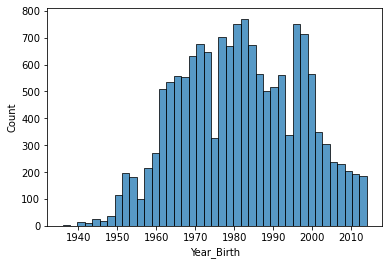

In [9]:
sns.histplot(data=data, x='Year_Birth')

<h2>Data Preprocessing</2>

<h3> Power Transformation for Reward Points <h3>

<p>We will now apply a power transformation to make data more Gaussian-like.</p>

<AxesSubplot:xlabel='RewardPoints', ylabel='Count'>

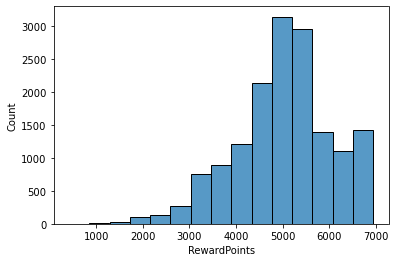

In [10]:
sns.histplot(data=data, x='RewardPoints', bins = 15)

In [11]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt.fit(data["RewardPoints"].values.reshape(-1, 1))
#print(pt.lambdas_)
data['RewardPoints'] = pt.transform(data["RewardPoints"].values.reshape(-1, 1))

<AxesSubplot:xlabel='RewardPoints', ylabel='Count'>

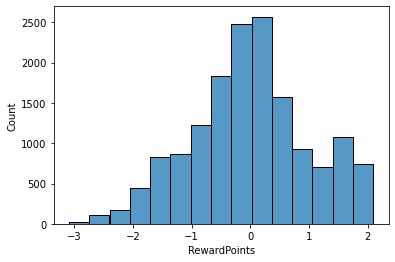

In [12]:
sns.histplot(data=data, x='RewardPoints', bins = 15)

<h3>Use KNN imputer for the missing values in Year_Birth <h3>

In [13]:
# creating an object for KNNImputer
imputer = KNNImputer(n_neighbors=5)

imputer.fit(data['Year_Birth'].values.reshape(-1, 1))
data['Year_Birth'] = imputer.transform(data['Year_Birth'].values.reshape(-1, 1))



In [14]:
data.head(28)
#the last value was missing and we obtained it with the help of KNN imputer

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.000000,business,single,-0.184038,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.000000,business,single,1.817457,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.000000,business,single,-0.700780,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.000000,leisure,double,-1.155980,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.000000,business,single,0.293787,2,2,...,5,5,5,5,5,3,4,1,3,5
5,6,churn,Ms. Morgan Briggs,yes,1975.000000,business,double,0.258212,2,2,...,3,2,2,2,2,2,2,4,2,1
6,7,churn,Ms. Kellie Alvarez,no,1990.000000,business,double,-0.182060,2,2,...,2,2,2,2,1,1,2,2,3,2
7,8,churn,Mr. Jorge Brown,yes,1976.000000,business,single,-0.994385,2,3,...,2,4,4,2,2,3,2,1,2,2
8,9,churn,Mr. Jesus Soto,yes,1974.000000,business,single,-1.285468,2,3,...,2,2,2,2,2,1,2,2,2,1
9,10,churn,Mr. Anthony Young,yes,1994.000000,business,single,-1.462554,3,5,...,3,3,3,3,4,3,4,1,4,3


In [15]:
data.isna().sum()

Cust_ID              0
Churn                0
Name                 0
Longevity            0
Year_Birth           0
TypeTravel           0
RoomType             0
RewardPoints         0
Comfort              0
ReceptionSchedule    0
FoodDrink            0
Location             0
Wifi                 0
Amenities            0
Staff                0
OnlineBooking        0
PriceQuality         0
RoomSpace            0
CheckOut             0
Checkin              0
Cleanliness          0
BarService           0
dtype: int64

<p> As demonstrated above, our data frame no longer has missing values. They have been imputed as the means of k-Nearest Neighbor values. </p>

<h3>Transform Year_birth to age</h3>

In [16]:
today = date.today()

age = today.year - data['Year_Birth']
print(age)

0        48.0
1        57.0
2        49.0
3        29.0
4        33.0
         ... 
15584    34.0
15585    22.0
15586    58.0
15587    30.0
15588    39.0
Name: Year_Birth, Length: 15589, dtype: float64


Text(0.5, 0, 'Age')

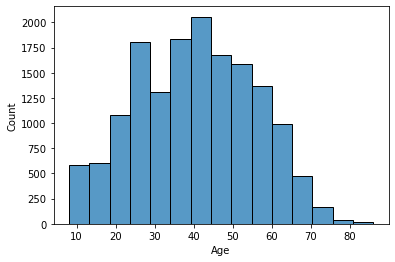

In [17]:
AgePlot = sns.histplot(data=age, x=age, bins = 15)
AgePlot.set_xlabel("Age")

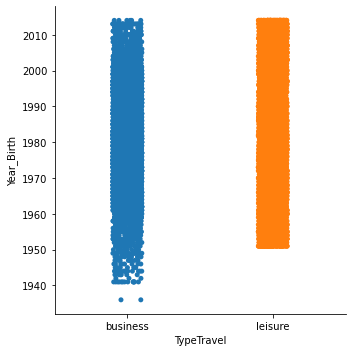

In [18]:
sns.catplot(x="TypeTravel", y = "Year_Birth" , data=data)

In [19]:
data.drop(data[(data['Year_Birth'] < 1937) & (data['TypeTravel'] == "business")].index, inplace = True)

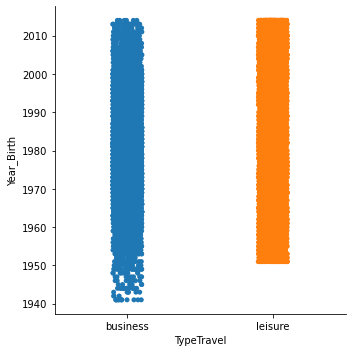

In [20]:
sns.catplot(x="TypeTravel", y = "Year_Birth" , data=data)

<h3>Transform Name in gender </h3>

In [21]:
gender = []
for i in data["Name"]:
    if i[:2] == "Mr":
        gender.append(1)
    else:
        gender.append(0)
        i
data["Name"] = gender
data = data.rename(columns = {"Name":"Male"})


In [22]:
data.head()

,Cust_ID,Churn,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,0,yes,1974.0,business,single,-0.184038,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,1,yes,1965.0,business,single,1.817457,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,1,yes,1973.0,business,single,-0.700780,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,0,yes,1993.0,leisure,double,-1.155980,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,1,yes,1989.0,business,single,0.293787,2,2,...,5,5,5,5,5,3,4,1,3,5


<h3>Change Data types</h3>

Replacing the data from longevity to 1 and 0
Yes=1 No=0

In [23]:
data['Longevity'].value_counts()

yes    12546
no      2874
y        167
Name: Longevity, dtype: int64

In [24]:
data['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
data['Longevity'].value_counts()

1    12713
0     2874
Name: Longevity, dtype: int64

<h3>Changing the Values of Column "TypeTravel"<h3>
 <p>business = 1 leisure = 0 <p>

In [25]:
data['TypeTravel'].value_counts()

business    10754
leisure      4833
Name: TypeTravel, dtype: int64

In [26]:
data['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
data['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
data['TypeTravel'].value_counts()

1    10754
0     4833
Name: TypeTravel, dtype: int64

<h3>Changing the Values of Column "Wifi"<h3>
 <p>6 were Replaced by 5 <p>

<AxesSubplot:xlabel='Wifi'>

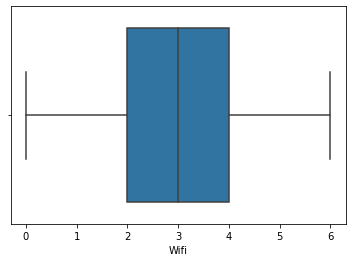

In [27]:
sns.boxplot(x="Wifi", data = data[['Wifi']])

In [28]:
data['Wifi'].value_counts()

4    3704
5    3446
3    3346
2    3245
1    1792
6      36
0      18
Name: Wifi, dtype: int64

In [29]:
data['Wifi'].replace(to_replace = 6,value = 5, inplace = True)
data['Wifi'].value_counts()

4    3704
5    3482
3    3346
2    3245
1    1792
0      18
Name: Wifi, dtype: int64

In [30]:
data['Wifi'].max()

5

<h3>Changing the Values of Column "Churn"<h3>
 <p>convert "churn" and "nochurn" to 1 (True) and 0 (False) <p>

In [31]:
data['Churn'].value_counts()

nochurn    8477
churn      7110
Name: Churn, dtype: int64

In [32]:
data['Churn'].replace(to_replace = 'churn',value = 1, inplace = True)
data['Churn'].replace(to_replace = 'nochurn',value = 0, inplace = True)
data['Churn'].value_counts()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15587 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15587 non-null  int64  
 1   Churn              15587 non-null  int64  
 2   Male               15587 non-null  int64  
 3   Longevity          15587 non-null  int64  
 4   Year_Birth         15587 non-null  float64
 5   TypeTravel         15587 non-null  int64  
 6   RoomType           15587 non-null  object 
 7   RewardPoints       15587 non-null  float64
 8   Comfort            15587 non-null  int64  
 9   ReceptionSchedule  15587 non-null  int64  
 10  FoodDrink          15587 non-null  int64  
 11  Location           15587 non-null  int64  
 12  Wifi               15587 non-null  int64  
 13  Amenities          15587 non-null  int64  
 14  Staff              15587 non-null  int64  
 15  OnlineBooking      15587 non-null  int64  
 16  PriceQuality       155

Change type of Year_birth to int32

<p>After applying the power transformation to Year_Birth, some years becama non-integer values. Since this does not make sense, we changed the type of this variable to int in order to round those values </p>

In [33]:
data['Year_Birth']=data['Year_Birth'].astype(int)
data.head(4)

,Cust_ID,Churn,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,1,0,1,1974,1,single,-0.184038,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,0,1,1,1965,1,single,1.817457,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,1,1,1,1973,1,single,-0.700780,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,0,0,1,1993,0,double,-1.155980,1,1,...,4,4,5,4,4,4,4,4,4,3


<h2>Room Type change</h2>

In [34]:
data['RoomType'].value_counts()

single    7440
double    7021
suite     1126
Name: RoomType, dtype: int64

<h3>Ordinal Encoding for column RoomType<h3>

In [35]:
data['RoomType'].replace(to_replace = 'suite',value = 2, inplace = True)
data['RoomType'].replace(to_replace = 'double',value = 1, inplace = True)
data['RoomType'].replace(to_replace = 'single',value = 0, inplace = True)
data['RoomType'].value_counts()

0    7440
1    7021
2    1126
Name: RoomType, dtype: int64

<h3>Pairplots to find out if there is a linear correlation between the variables<h3>

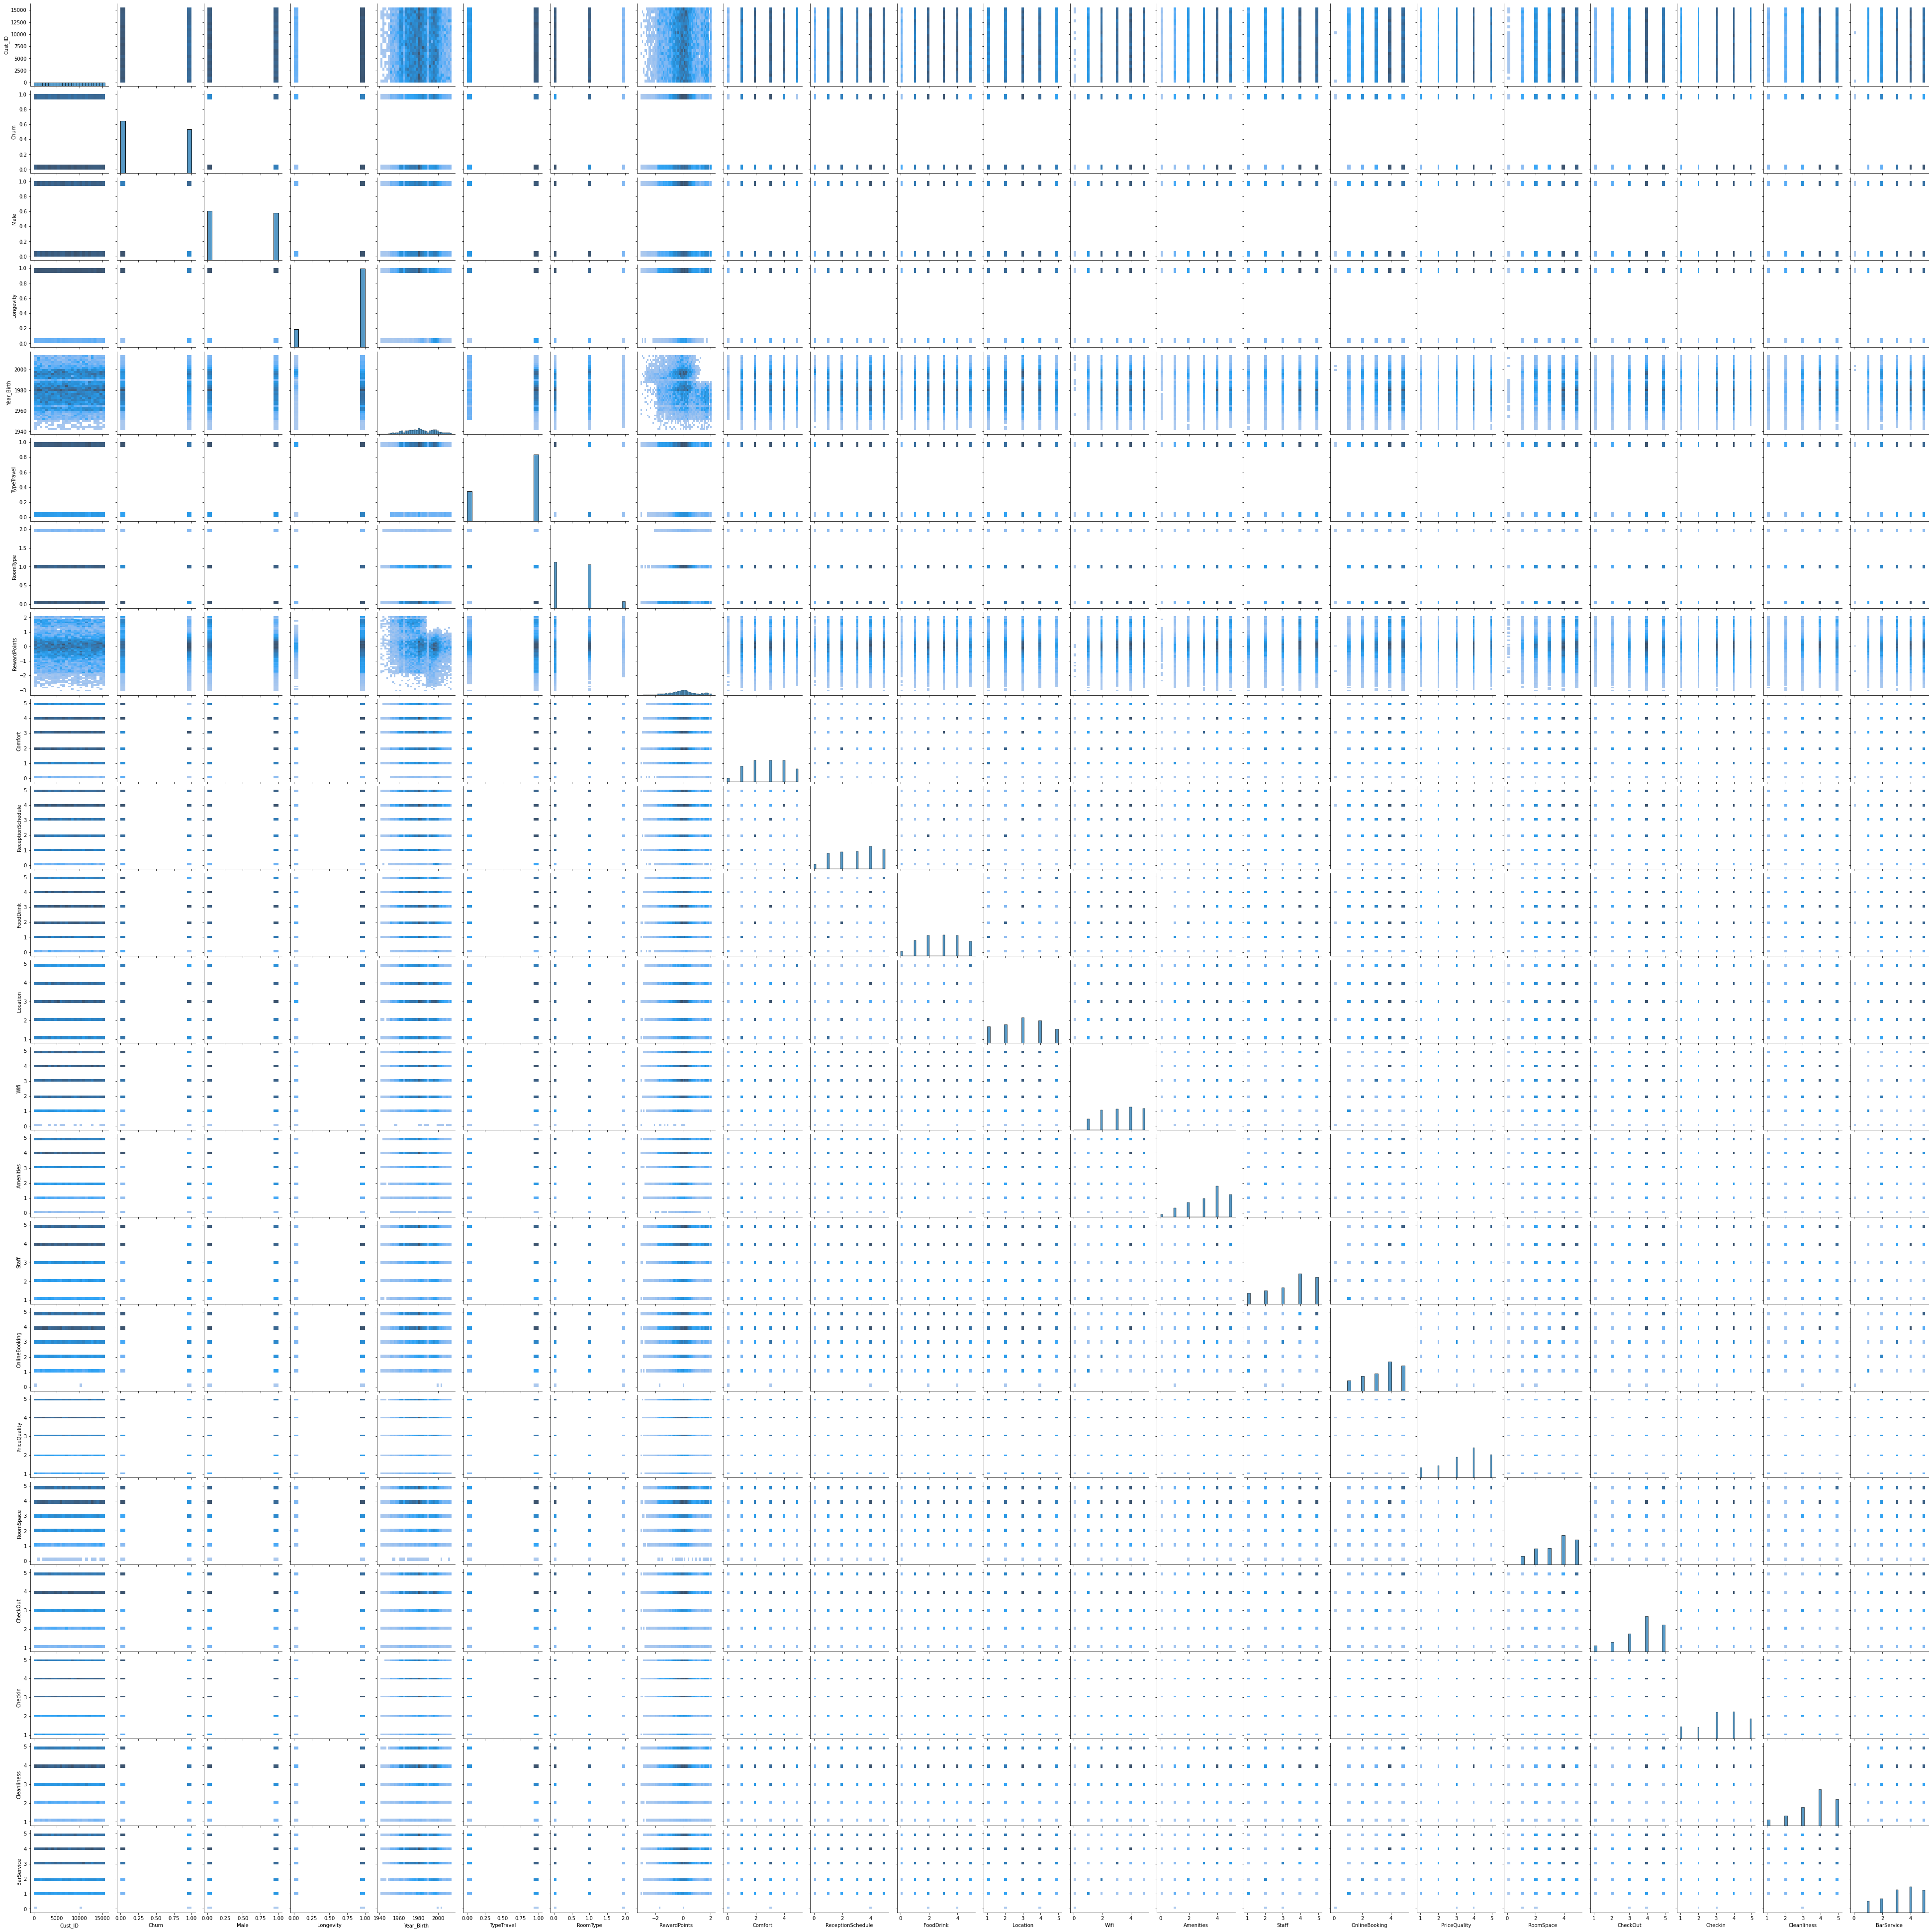

In [35]:
sns.pairplot(data, kind="hist") 

In [36]:
sns.pairplot(data, kind="kde") 

<h3>Pearson Correlation Heatmap</h3>

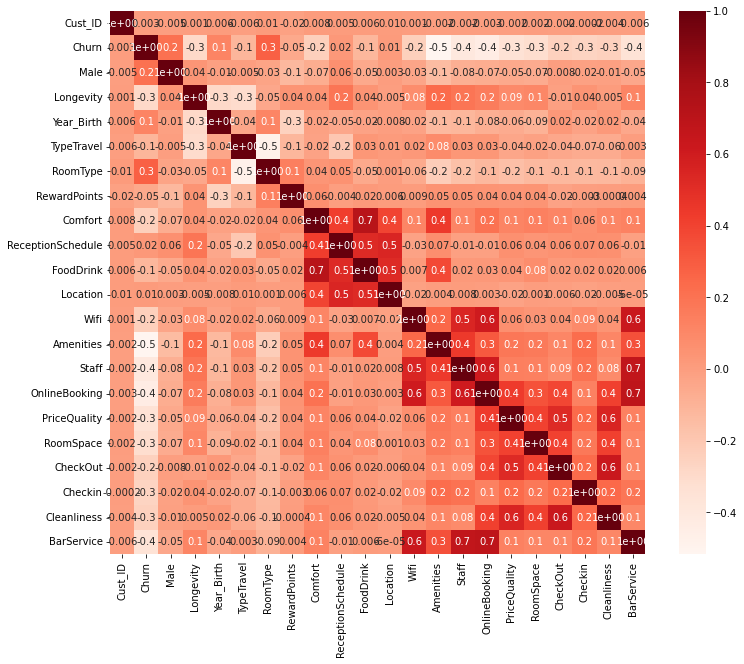

In [36]:
#Pearson correlation
cor_pearson= data.corr(method ='pearson')
#Heatmap function defined
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
#print correlation
cor_heatmap(cor_pearson)

<h3>Kendall Correlation Heatmap</h3>

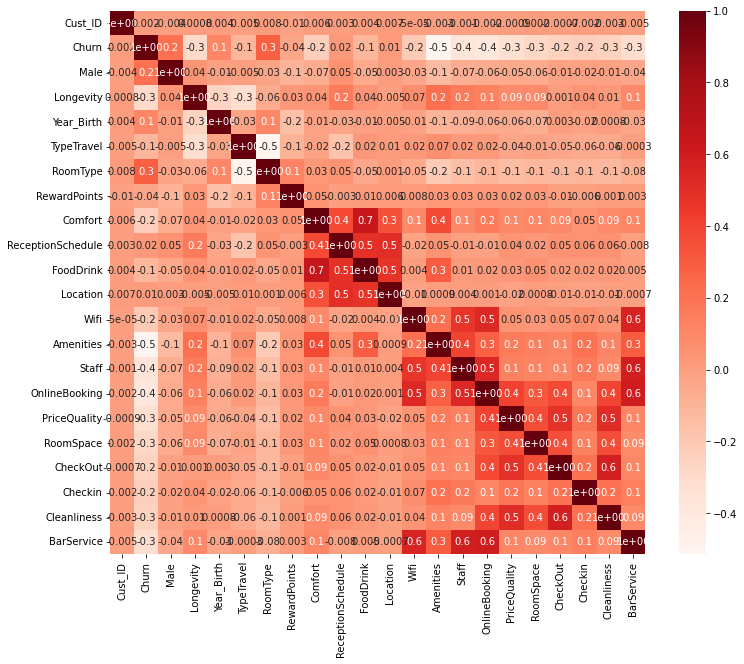

In [37]:
#Kendall correlation
cor_kendall= data.corr(method ='kendall')
#Heatmap function defined
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
#print correlation
cor_heatmap(cor_kendall)

<h3>Feature Selection</h3>

<p>With the correlation map we were able see which features had a greater impact on the outcome (Churn) and which ones didn't. It also allowed us to see that there are some features that have a high correlation between them, making it redundant to keep both. </p>

In [38]:
data.drop(columns=['Wifi', 'Cust_ID', 'Location'], inplace=True)

<h3>Scale the data<h3>

<p>Since variables that are measured at different scales do not contribute equally to the model fitting and model learned function and might end up creating a bias, we will deal with this potential problem by applying a MinMax Normalization.</p>

In [39]:
X_train = data.drop('Churn', axis = 1)
y_train = data['Churn']

scaler = MinMaxScaler().fit(X_train)
minmax_train = scaler.transform(X_train)

X_train = pd.DataFrame(minmax_train, columns = X_train.columns)
X_train.head()

,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,0.0,1.0,0.452055,1.0,0.0,0.560708,0.6,0.8,0.2,0.6,0.75,0.6,0.50,0.6,0.50,0.75,0.50,0.8
1,1.0,1.0,0.328767,1.0,0.0,0.946696,0.2,0.2,0.2,0.6,0.75,1.0,1.00,1.0,1.00,0.00,1.00,0.4
2,1.0,1.0,0.438356,1.0,0.0,0.461055,0.6,0.6,0.6,0.8,0.75,0.6,0.50,0.4,0.50,0.25,0.50,0.2
3,0.0,1.0,0.712329,0.0,0.5,0.373270,0.2,0.2,0.2,0.8,1.00,0.8,0.75,0.8,0.75,0.75,0.75,0.6
4,1.0,1.0,0.657534,1.0,0.0,0.652857,0.4,0.4,0.6,1.0,1.00,1.0,1.00,0.6,0.75,0.00,0.50,1.0


ANOVA

In [40]:
anova = SelectKBest(f_classif, k=15)
X_anova = anova.fit_transform(X_train, y_train)
selected_features = pd.Series(anova.get_support(), index = X_train.columns)
selected_features

Male                  True
Longevity             True
Year_Birth            True
TypeTravel           False
RoomType              True
RewardPoints         False
Comfort               True
ReceptionSchedule    False
FoodDrink             True
Amenities             True
Staff                 True
OnlineBooking         True
PriceQuality          True
RoomSpace             True
CheckOut              True
Checkin               True
Cleanliness           True
BarService            True
dtype: bool

<h1>VALIDATION<h1>

<h2>Data preparation<h2>

In [41]:
#get the validation data
filename1 = 'validation.csv'
file_path1 = Path(filename1)
v = pd.read_csv(file_path1, delimiter=";")
validate = v.copy()
#Longevity
validate['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
validate['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
validate['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
#TypeTravel
validate['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
validate['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
#Churn
validate['Churn'].replace(to_replace = 'churn',value = 1, inplace = True)
validate['Churn'].replace(to_replace = 'nochurn',value = 0, inplace = True)
#RoomType
validate['RoomType'].replace(to_replace = 'suite',value = 2, inplace = True)
validate['RoomType'].replace(to_replace = 'double',value = 1, inplace = True)
validate['RoomType'].replace(to_replace = 'single',value = 0, inplace = True)

#PowerTransformation for RewardPoints
validate['RewardPoints'] = pt.transform(validate["RewardPoints"].values.reshape(-1, 1))

#name to gender conversion
gender = []
for i in validate["Name"]:
    if i[:2] == "Mr":
        gender.append(1)
    else:
        gender.append(0)
        i
validate["Name"] = gender
validate = validate.rename(columns = {"Name":"Male"})

#column removal 
validate.drop(columns=['Wifi', 'Cust_ID', 'Location'], inplace=True)

validate.head(2)

,Churn,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,0,1,0,2001,1,0,-0.564469,5,0,5,5,4,4,3,2,4,3,4,4
1,0,1,1,1965,1,0,0.635638,1,1,1,4,4,5,5,5,5,5,5,5


<h2>Checking Missing values<h2>

In [42]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Churn              5195 non-null   int64  
 1   Male               5195 non-null   int64  
 2   Longevity          5195 non-null   int64  
 3   Year_Birth         5195 non-null   int64  
 4   TypeTravel         5195 non-null   int64  
 5   RoomType           5195 non-null   int64  
 6   RewardPoints       5195 non-null   float64
 7   Comfort            5195 non-null   int64  
 8   ReceptionSchedule  5195 non-null   int64  
 9   FoodDrink          5195 non-null   int64  
 10  Amenities          5195 non-null   int64  
 11  Staff              5195 non-null   int64  
 12  OnlineBooking      5195 non-null   int64  
 13  PriceQuality       5195 non-null   int64  
 14  RoomSpace          5195 non-null   int64  
 15  CheckOut           5195 non-null   int64  
 16  Checkin            5195 

<h2>Scaling<h2>

In [43]:
#Drop name column
#Scaling

X_validate = validate.drop('Churn', axis = 1)
y_validate = validate['Churn']

minmax_validate = scaler.transform(X_validate)

X_validate = pd.DataFrame(minmax_validate, columns = X_validate.columns)
X_validate.head()

,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1.0,0.0,0.821918,1.0,0.0,0.487342,1.0,0.0,1.0,1.0,0.75,0.8,0.50,0.4,0.75,0.50,0.75,0.8
1,1.0,1.0,0.328767,1.0,0.0,0.718783,0.2,0.2,0.2,0.8,0.75,1.0,1.00,1.0,1.00,1.00,1.00,1.0
2,0.0,1.0,0.726027,0.0,0.5,0.481572,1.0,1.0,1.0,0.2,0.00,1.0,1.00,1.0,0.75,1.00,1.00,1.0
3,0.0,1.0,0.575342,1.0,0.0,0.396052,0.4,0.6,0.2,0.8,0.75,0.4,0.25,0.4,0.25,0.75,0.25,0.8
4,0.0,1.0,0.301370,1.0,0.0,0.723194,0.8,0.8,0.8,1.0,0.75,0.6,0.50,0.8,0.50,0.75,0.50,0.6


<h1>TEST<h1>

<h2>Data Preparation<h2>

In [44]:
#get the test data
filename2 = 'test.csv'
file_path2 = Path(filename2)
t = pd.read_csv(file_path2, delimiter=";")
test = t.copy()
#Longevity
test['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
test['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
test['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
#TypeTravel
test['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
test['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
#RoomType
test['RoomType'].replace(to_replace = 'suite',value = 2, inplace = True)
test['RoomType'].replace(to_replace = 'double',value = 1, inplace = True)
test['RoomType'].replace(to_replace = 'single',value = 0, inplace = True)

#PowerTransformation for RewardPoints
test['RewardPoints'] = pt.transform(test["RewardPoints"].values.reshape(-1, 1))

#name to gender conversion
gender = []
for i in test["Name"]:
    if i[:2] == "Mr":
        gender.append(1)
    else:
        gender.append(0)
        i
test["Name"] = gender
test = test.rename(columns = {"Name":"Male"})

#column removal 
customers = test['Cust_ID']
test.drop(columns=['Wifi', 'Cust_ID', 'Location'], inplace=True)

test.head(2)

,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,1,1956,0,1,0.514551,2,4,2,2,1,1,5,3,4,4,4,1
1,1,1,2004,0,1,0.938319,2,4,2,2,4,4,4,5,4,3,1,4


<h2>Scalling<h2>

In [45]:
#Scaling

X_test = test

minmax_test = scaler.transform(X_test)

X_test = pd.DataFrame(minmax_test, columns = X_test.columns)
X_test.head()


,Male,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1.0,1.0,0.205479,0.0,0.5,0.695431,0.4,0.8,0.4,0.4,0.00,0.2,1.00,0.6,0.75,0.75,0.75,0.2
1,1.0,1.0,0.863014,0.0,0.5,0.777154,0.4,0.8,0.4,0.4,0.75,0.8,0.75,1.0,0.75,0.50,0.00,0.8
2,1.0,0.0,0.698630,1.0,0.0,0.602282,1.0,0.8,0.8,0.8,0.00,0.4,1.00,1.0,1.00,0.50,0.75,0.4
3,1.0,1.0,0.616438,0.0,0.5,0.636959,0.8,1.0,0.8,0.8,0.50,0.6,0.50,1.0,1.00,0.50,0.75,0.6
4,0.0,1.0,0.397260,1.0,0.5,0.793873,0.8,0.4,0.4,0.8,0.50,0.8,0.75,0.8,0.75,0.75,0.75,0.8


<h3>Models<h3>

<h3>Model Evaluation Functions</h3>

In [46]:
def avg_score(model):
    score_train = []
    score_val = []
    timer = []
    f1_score_val = []
    f1_score_train = []
    
    for i in range(10):
        begin = time.perf_counter() # start counting time
        model.fit(X_train, y_train) # fit your model to your training data
        end = time.perf_counter() # stop counting time
        
        value_train = model.score(X_train, y_train) # mean accuracy for train
        value_val = model.score(X_validate, y_validate) # mean accuracy for validation
        score_train.append(value_train) # append the mean accuracy in train to your list score_train
        score_val.append(value_val) # append the mean accuracy in validation to your list score_val
        timer.append(end-begin) # append the time to your list timer
        f1_score_val.append(f1_score(model.predict(X_validate), y_validate))
        f1_score_train.append(f1_score(model.predict(X_train), y_train))
        
    
    avg_time = round(np.mean(timer),3) # check the mean value of training time for your 10 models 
    avg_train = round(np.mean(score_train),3) # check the mean accuracy in train for your 10 models
    avg_val = round(np.mean(score_val),3) # check the mean accuracy in validation for your 10 models
    std_time = round(np.std(timer),2) # check the standard deviation of training time for your 10 models
    std_train = round(np.std(score_train),2) # check the standard deviation of the mean accuracy in train for your 10 models
    std_val = round(np.std(score_val),2) # check the standard deviation of the mean accuracy in validation for your 10 models
    avg_f1_val = round(np.mean(f1_score_val),3)
    avg_f1_train = round(np.mean(f1_score_train),3)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_val) + '+/-' + str(std_val), str(avg_f1_train), str(avg_f1_val)

In [47]:
def show_results(df, models):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        # obtain the results provided by avg_score
        time, avg_train, avg_val, avg_f1_train, avg_f1_val = avg_score(model)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_val, avg_f1_train, avg_f1_val
        count+=1
    return df

<h2>KNN Classifier</h2>

<p>The KNN Classifier is a classification algorithm in which a new data point is classified based on similarity in the specific group of neighboring data points. We will start by  creating a Nearest Neighbor classifier instance called modelKNN, to which we will fit the array of points X_train and y_train. Then, we use the predict() method of modelKNN to perform classification in X_train and assign to the object labels_train.</p>


In [48]:
modelKNN = KNeighborsClassifier()

In [49]:
df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Raw'])
show_results(df, [modelKNN])

,Time,Train,Validation,F1 Train,F1 Validation
Raw,0.007+/-0.01,0.935+/-0.0,0.909+/-0.0,0.93,0.904


<h3>Decision Trees<h3>

In [ ]:
modelDT = DecisionTreeClassifier(splitter = 'random',criterion = 'entropy',random_state=5,max_depth = 10, min_samples_split=4,min_samples_leaf=5)

In [ ]:
df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Raw'])
show_results(df, [modelDT])

,Time,Train,Validation,F1 Train,F1 Validation
Raw,0.033+/-0.01,0.929+/-0.0,0.925+/-0.0,0.922,0.918


In [ ]:
print('The defined three has a depth of ' + str(modelDT.get_depth()) + ', ' + str(modelDT.tree_.node_count) + 
      ' nodes and a total of ' + str(modelDT.get_n_leaves()) + ' leaves.')

The defined three has a depth of 10, 503 nodes and a total of 252 leaves.


In [ ]:
modelDT.feature_importances_

array([0.04694366, 0.05799303, 0.00573598, 0.02721146, 0.03195863,
       0.00217525, 0.26770429, 0.03810845, 0.04006144, 0.22667587,
       0.01650314, 0.17668929, 0.00548213, 0.00759376, 0.01687617,
       0.01706584, 0.00419714, 0.01102444])

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

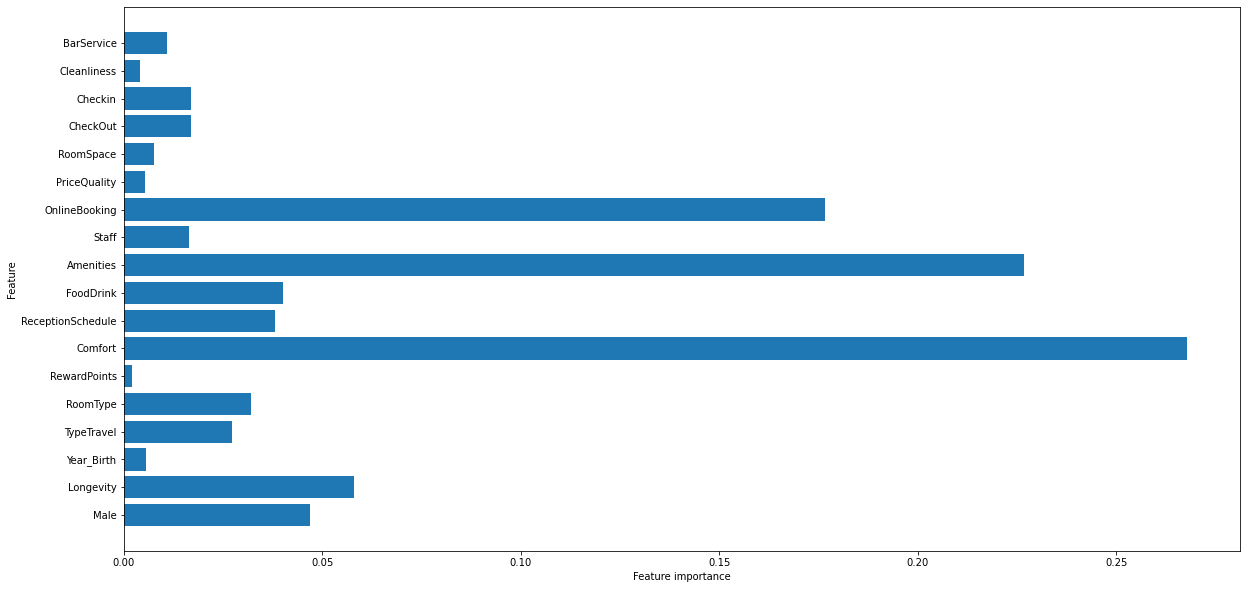

In [ ]:
plot_feature_importances(modelDT)

<h3>Logistic Regression</h3>

In [50]:
model_log_reg = LogisticRegression(class_weight='balanced')
model_log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [51]:
labels_train = model_log_reg.predict(X_train)
labels_val = model_log_reg.predict(X_validate)

print('----------------------- TRAIN -----------------------')
print(classification_report(y_train, labels_train))
print('--------------------- VALIDATION ---------------------')
print(classification_report(y_validate, labels_val))

----------------------- TRAIN -----------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      8477
           1       0.80      0.84      0.82      7110

    accuracy                           0.83     15587
   macro avg       0.83      0.84      0.83     15587
weighted avg       0.84      0.83      0.83     15587

--------------------- VALIDATION ---------------------
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      2831
           1       0.80      0.85      0.83      2364

    accuracy                           0.84      5195
   macro avg       0.83      0.84      0.84      5195
weighted avg       0.84      0.84      0.84      5195



<h3>Neural Networks</h3>

In [ ]:
modelMLP = MLPClassifier()

In [ ]:
df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Raw'])
show_results(df, [modelMLP])

C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multi

,Time,Train,Validation,F1 Train,F1 Validation
Raw,25.241+/-1.31,0.945+/-0.0,0.937+/-0.0,0.94,0.932


In [ ]:
model_simple = MLPClassifier(hidden_layer_sizes=(5))
model_medium = MLPClassifier(hidden_layer_sizes=(10,10))
model_complex = MLPClassifier(hidden_layer_sizes=(20, 20))

df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Simple','Medium','Complex'])
show_results(df, [model_simple, model_medium, model_complex])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

,Time,Train,Validation,F1 Train,F1 Validation
Simple,6.745+/-0.13,0.899+/-0.01,0.898+/-0.01,0.888,0.888
Medium,9.461+/-0.38,0.924+/-0.0,0.922+/-0.0,0.917,0.915
Complex,10.753+/-0.22,0.937+/-0.0,0.93+/-0.0,0.932,0.925


In [ ]:
model_logistic = MLPClassifier(activation='logistic')
model_tanh = MLPClassifier(activation='tanh')
model_relu = MLPClassifier(activation='relu')
model_identity = MLPClassifier(activation='identity')

df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['logistic','tanh', 'relu', 'identity'])
show_results(df, [model_logistic, model_tanh, model_relu, model_identity])

C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multi

,Time,Train,Validation,F1 Train,F1 Validation
logistic,20.486+/-1.98,0.885+/-0.0,0.884+/-0.0,0.873,0.874
tanh,23.663+/-0.75,0.927+/-0.0,0.925+/-0.0,0.92,0.918
relu,21.411+/-1.15,0.946+/-0.0,0.938+/-0.0,0.941,0.933
identity,2.754+/-0.39,0.833+/-0.0,0.834+/-0.0,0.818,0.82


In [ ]:
model_sgd = MLPClassifier(solver = 'sgd')
model_adam = MLPClassifier(solver = 'adam')
model_lbfgs = MLPClassifier(solver = 'lbfgs')

df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['sgd','adam', 'lbfgs'])
show_results(df, [model_sgd, model_adam, model_lbfgs])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

,Time,Train,Validation,F1 Train,F1 Validation
sgd,11.335+/-0.15,0.888+/-0.0,0.885+/-0.0,0.877,0.876
adam,13.318+/-0.82,0.946+/-0.0,0.937+/-0.0,0.941,0.932
lbfgs,5.175+/-0.36,0.942+/-0.0,0.934+/-0.0,0.936,0.929


In [ ]:
model_constant = MLPClassifier(solver = 'sgd', learning_rate = 'constant')
model_invscaling = MLPClassifier(solver = 'sgd', learning_rate = 'invscaling')

df = pd.DataFrame(columns = ['Time','Train','Validation', 'f1 Train', 'f1 Validation'], index = ['constant','invscaling'])
show_results(df, [model_constant, model_invscaling])

C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manue\anaconda3\lib\site-packages\sklearn\neural_network\_multi

,Time,Train,Validation,f1 Train,f1 Validation
constant,27.649+/-1.93,0.946+/-0.0,0.938+/-0.0,0.941,0.932
invscaling,26.711+/-1.68,0.946+/-0.0,0.937+/-0.0,0.94,0.931


In [ ]:
parameter_space = { #we still need to adjust these parameters
    'hidden_layer_sizes': [(20,20)],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.00001, 0.001, 0.1],
    'learning_rate': ['constant', 'invscaling']
}

In [ ]:
clf = RandomizedSearchCV(modelMLP, parameter_space)
clf.fit(X_train, y_train)
clf.best_params_
final_model = clf.best_estimator_

df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['final_model'])
show_results(df, [final_model])

NameError: name 'RandomizedSearchCV' is not defined

In [ ]:
final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20),
              learning_rate_init=0.1, solver='sgd')

In [ ]:
print(final_model.predict(X_validate))

[0 0 0 ... 0 0 0]


In [ ]:
final_model.score(X_train, y_train)

0.9540060298928732

In [ ]:
final_model.score(X_validate, y_validate)

0.931665062560154

<h3> Linear SVC Model </h3>

In [ ]:
X_train, y_train = make_classification(n_features=18, random_state=0)
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))

In [ ]:
df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Linear SVC'])
show_results(df, [clf])

,Time,Train,Validation,F1 Train,F1 Validation
Raw,0.007+/-0.0,0.93+/-0.0,0.455+/-0.0,0.929,0.625


<h3>Gaussian Naive Bayes Model</h3>

In [ ]:
clf = GaussianNB()

df = pd.DataFrame(columns = ['Time','Train','Validation','F1 Train','F1 Validation'], index = ['Raw'])
show_results(df, [clf])

,Time,Train,Validation,F1 Train,F1 Validation
Raw,0.018+/-0.0,0.826+/-0.0,0.822+/-0.0,0.811,0.808


<h3>Random Forest</h3>

In [ ]:
model_randomForest = RandomForestClassifier()

In [ ]:
model_gini = RandomForestClassifier(criterion='gini')
model_entropy= RandomForestClassifier(criterion='entropy')

df = pd.DataFrame(columns = ['Time','Train','Validation', 'f1 Train', 'f1 Validation'], index = ['gini','entropy'])
show_results(df, [model_gini, model_entropy])

,Time,Train,Validation,f1 Train,f1 Validation
gini,2.04+/-0.11,1.0+/-0.0,0.945+/-0.0,1.0,0.94
entropy,2.26+/-0.09,1.0+/-0.0,0.945+/-0.0,1.0,0.94


In [ ]:
model_small_maxdepth = RandomForestClassifier(max_depth=5)
model_medium_maxdepth = RandomForestClassifier(max_depth=10)
model_big_maxdepth = RandomForestClassifier(max_depth=15)

df = pd.DataFrame(columns = ['Time','Train','Validation', 'f1 Train', 'f1 Validation'], index = ['small','medium', 'big'])
show_results(df, [model_small_maxdepth, model_medium_maxdepth, model_big_maxdepth])

,Time,Train,Validation,f1 Train,f1 Validation
small,1.066+/-0.06,0.896+/-0.0,0.903+/-0.0,0.884,0.892
medium,2.064+/-0.38,0.949+/-0.0,0.931+/-0.0,0.944,0.925
big,2.341+/-0.82,0.99+/-0.0,0.942+/-0.0,0.99,0.937


In [ ]:
model_small_min_samples_leaf = RandomForestClassifier(min_samples_leaf=3)
model_medium_min_samples_leaf = RandomForestClassifier(min_samples_leaf=5)
model_big_min_samples_leaf = RandomForestClassifier(min_samples_leaf=8)

df = pd.DataFrame(columns = ['Time','Train','Validation', 'f1 Train', 'f1 Validation'], index = ['small','medium', 'big'])
show_results(df, [model_small_min_samples_leaf, model_medium_min_samples_leaf, model_big_min_samples_leaf])

,Time,Train,Validation,f1 Train,f1 Validation
small,2.421+/-0.18,0.981+/-0.0,0.939+/-0.0,0.979,0.934
medium,2.325+/-0.42,0.964+/-0.0,0.936+/-0.0,0.961,0.93
big,1.828+/-0.11,0.949+/-0.0,0.933+/-0.0,0.944,0.927


In [ ]:
parameter_space_random_forest = {
    'n_estimators': [100, 250, 500],
    'criterion': ['gini'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10], 
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
clf = GridSearchCV(model_randomForest, parameter_space_random_forest)
clf.fit(X_train, y_train)
clf.best_params_
final_model_forest = clf.best_estimator_

df = pd.DataFrame(columns = ['Time','Train','Validation', 'f1 Train', 'f1 Validation'], index = ['final_model_forest'])
show_results(df, [final_model_forest])

KeyboardInterrupt: 

In [ ]:
final_model_forest.fit(X_train, y_train)
print(final_model_forest.predict(X_validate))
final_model_forest.score(X_train, y_train)
final_model_forest.score(X_validate, y_validate)

In [57]:
deploy = model_log_reg.predict(X_test)
answer = pd.DataFrame([customers, deploy]).T
answer = answer.rename(columns={"Cust_ID": "Customer ID", "Unnamed 0": "Churn"})
answer.to_excel('202122 Spring Lic Group06 Answer With Log Reg .xlsx', index = False)